# **SAPIENS**: Structuring multi-Agent toPology for Innovation through ExperieNce Sharing
---


SAPIENS is a reinforcement learning algorithm where multiple **off-policy agents** solve the same task in parallel and exchange experiences on the go. The group is characterized by its **topology**, a graph that determines who communicates with whom.

In the current implementation all agents are DQNs and exchange experiences have the form of **transitions from their replay buffers**. 

In this notebook, we will see two examples of using SAPIENS: One with a fully-connected topology and one where the topology is **dynamic**. 

We will use [Wordcraft](https://github.com/minqi/wordcraft), a gym environment inspired from the Little Alchemy game,  as our test-bed. We are using our own version of Wordcraft, under [lib/wordcraft](lib/wordcraft), as we have made slight modifications to the original playground (added more recipe books with simpler elements, removed notion of goal state, wrapped the observation/action spaces). 

In particular we will see:


* how to set up SAPIENS with all package dependencies
* how we define an innovation task in Wordcraft as a gym environment
* how to train SAPIENS with a fully-connected topology of 10 agents
* how to train SAPIENS with a dynamic topology of 10 agents
* how to visualize and compare the innovation abilities of groups

## How to set up SAPIENS with all package dependencies

We just need to clone the github repository. 

(To remain anonynmous we don't clone the github repository here. Instead you can download it as zip-file [here](https://drive.google.com/file/d/17BRxdssTcmYIK9NhQX18_5MERz8kIo4M/view?usp=sharing) and upload it to your Google Drive. Alternatively you can download it from [the anonymous repo](https://anonymous.4open.science/r/SAPIENS-859E) and upload it as a zip from the Files menu.)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip gdrive/My\ Drive/SAPIENS.zip
%cd /content/SAPIENS









Mounted at /content/gdrive
Archive:  gdrive/My Drive/SAPIENS.zip
   creating: SAPIENS/
   creating: SAPIENS/.git/
   creating: SAPIENS/.git/hooks/
  inflating: SAPIENS/.git/hooks/applypatch-msg.sample  
  inflating: SAPIENS/.git/hooks/pre-push.sample  
  inflating: SAPIENS/.git/hooks/pre-applypatch.sample  
  inflating: SAPIENS/.git/hooks/update.sample  
  inflating: SAPIENS/.git/hooks/pre-commit.sample  
  inflating: SAPIENS/.git/hooks/commit-msg.sample  
  inflating: SAPIENS/.git/hooks/pre-rebase.sample  
  inflating: SAPIENS/.git/hooks/pre-receive.sample  
  inflating: SAPIENS/.git/hooks/post-update.sample  
  inflating: SAPIENS/.git/hooks/fsmonitor-watchman.sample  
  inflating: SAPIENS/.git/hooks/prepare-commit-msg.sample  
  inflating: SAPIENS/.git/description  
   creating: SAPIENS/.git/info/
  inflating: SAPIENS/.git/info/exclude  
   creating: SAPIENS/.git/branches/
   creating: SAPIENS/.git/refs/
   creating: SAPIENS/.git/refs/heads/
  inflating: SAPIENS/.git/refs/heads/maste

##  

## How to create a gym environment that defines an innovation task in Wordcraft 

In Wordcraft, we use a recipe book to describe the task. We provide three recipe books under [SAPIENS/lib/wordcraft/recipe_books](SAPIENS/lib/wordcraft/recipe_books).

In this notebook, we will experiment with the single_path recipe book, where an agent can craft elements on ten different paths and one of the paths is the most rewarding.

Each agent has its own copy of an environment for training and an environment for our evaluation.


In [ ]:
# define a training and evaluation environment for each agent

import gym 
import copy

def build_envs(recipe_path=""):
    """
    Environment generation tool

    Params
    ----------
   
    recipe_path : string, default = ".",
        path to the recipe book used to generate the environment

    """
    
    env_name="wordcraft-multistep-no-goal-v0"
    # use gym to generate the environment with the required parameters
    env = gym.make(
        env_name,
        max_depth=8,
        max_mix_steps=8,
        num_distractors=0,
        subgoal_rewards=True,
        data_path=recipe_path,
        feature_type="one_hot"
    )

    # apply wrappers
    wrapper = SquashWrapper
    env = wrapper(env, proportional=True)
    env= FlattenObservation(env)

    env.reset()


    eval_env = copy.deepcopy(env)
    eval_env.reset()

    return env, eval_env


from lib.wordcraft.utils.task_utils import recipe_book_info
from gym.wrappers import FlattenObservation
from lib.wordcraft.wrappers.squash_wrapper import SquashWrapper
import lib.wordcraft 
from lib.wordcraft.wordcraft.env_nogoal import WordCraftEnvNoGoal

recipe_book = "single_path" # other options: "single_path" and "merging_paths"
train_envs = []
eval_envs = []

n_agents = 10
for i in range(n_agents):
        train_env, eval_env = build_envs(
            recipe_path=recipe_book_info[recipe_book]["path"]
        )
        train_envs.append(train_env)
        eval_envs.append(eval_env)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## How to train SAPIENS with a fully-connected topology of 10 agents

To configure SAPIENS we need to provide information about the social network topology and the hyperparameterisation of the DQN (all DQNs share the same hyperparameters).

Below we fix the hyper-parameters: discount-factor, buffer size and batch size and define a topology with 10 fully-connected agents 

We also pick a name for our current experiment, which will have its own directory under the projects directory and the number of training episodes (in all our tasks an episode requires 16 environment interations).



In [ ]:
from sapiens.sapiens import Sapiens


# set DQN hyper-parameters
gamma = 0.9
buffer_size = 5000
batch_size = 64 
num_neurons = 64
num_layers = 2 

# set social network topology
n_agents = 10
shape = "fully-connected"
total_episodes = 10000
project_path = "projects/test_fully"
n_trials=2

# we opt for measuring mnemonic metrics and inter-group alignment (this significantly increases the size of the models directory)
measure_mnemonic = True
measure_intergroup_alignment = True

group = Sapiens(gamma=gamma,
                buffer_size=buffer_size,
                batch_size=batch_size,
                num_neurons=num_neurons,
                num_layers=num_layers,
                n_agents=n_agents,
                shape=shape,
                train_envs=train_envs,
                eval_envs=eval_envs,
                project_path=project_path,
                total_episodes=total_episodes,
                measure_mnemonic=measure_mnemonic,
                measure_intergroup_alignment=measure_intergroup_alignment,
                n_trials=n_trials)
group.learn()





'\ngroup = Sapiens(gamma=gamma,\n                buffer_size=buffer_size,\n                batch_size=batch_size,\n                num_neurons=num_neurons,\n                num_layers=num_layers,\n                n_agents=n_agents,\n                shape=shape,\n                train_envs=train_envs,\n                eval_envs=eval_envs,\n                project_path=project_path,\n                total_episodes=total_episodes,\n                measure_mnemonic=measure_mnemonic,\n                measure_intergroup_alignment=measure_intergroup_alignment,\n                n_trials=n_trials)\ngroup.learn()\n'

With training complete, we can inspect our project directory. There, we have saved:

* a config.yaml file containing the hyper-parameters of the experiment
* a subdirectory for each trial which contains:
  * models saved for evaluation. We have kept record of models for all agents every 10000 training time steps
  * visualization plots for inspecting the topology and the evaluation

To compute evaluation metrics and produce plots for this project we can use the script [scripts/eval_project.py]. This will produce data files with the metrics under the project's  data directory and plots under the plots directory

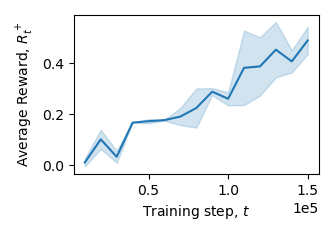

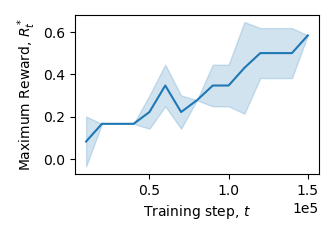

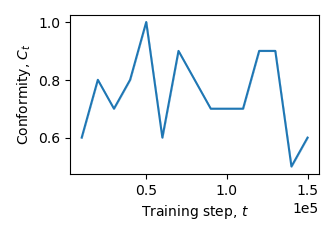

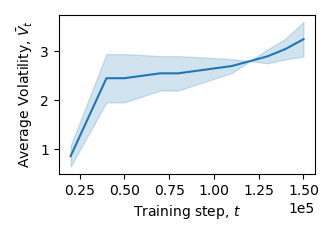

In [ ]:
# we can visualize the topology of the group

##!apt-get update
#!apt install libmagickwand-dev
#!apt install imagemagick
#!pip install wand
from IPython.display import Image
from IPython.display import display


Image("projects/test_fully/plots/network.png")

# we then evaluate the project (compute all metrics discussed in Section 2.4 )
from scripts.evaluate import evaluate_project

# evaluate projects (we compute averages across all trials)
evaluate_project(project_path)



display(Image("projects/test_fully/plots/avg_norm_reward.png"), Image("projects/test_fully/plots/max_norm_reward.png"), Image("projects/test_fully/plots/avg_group_conformity.png"),Image("projects/test_fully/plots/avg_volatility.png"))









## How to train SAPIENS with a dynamic topology

Similarly to above, we now train a dynamic topology. We here use the dynamic-Boyd topology, which can be tuned through these 3 hyper-parameters:

* number of sub-groups: initially the dynamic structure has agents divided into independent sub-groups

* migrate rate: the probability of one agent leaving its current sub-group to visit another sub-group

* visit duration: the number of training time steps that the visit lasts for



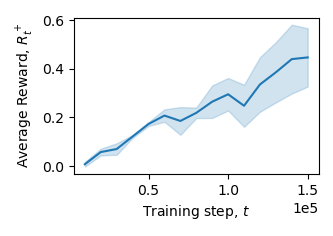

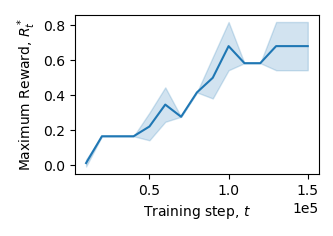

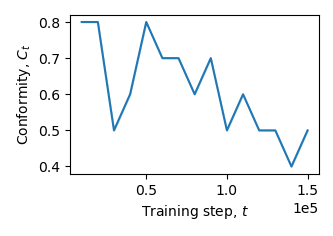

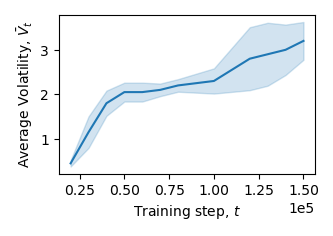

In [ ]:
from sapiens.sapiens import Sapiens


# set DQN hyper-parameters
gamma = 0.9
buffer_size = 5000
batch_size = 64 
num_neurons = 64
num_layers = 2 

# set social network topology
n_agents = 10
shape = "dynamic-Boyd"
migrate_rate = 0.01
visit_duration = 10
n_subgroups = 5

total_episodes = 10000
project_path = "projects/test_dynamic"
n_trials = 2

# we opt for measuring mnemonic metrics and inter-group alignment (this significantly increases the size of the models directory)
measure_mnenonic = True
measure_intergroup_alignment = True

group = Sapiens(gamma=gamma,
                buffer_size=buffer_size,
                batch_size=batch_size,
                num_neurons=num_neurons,
                num_layers=num_layers,
                n_agents=n_agents,
                shape=shape,
                train_envs=train_envs,
                eval_envs=eval_envs,
                project_path=project_path,
                total_episodes=total_episodes,
                migrate_rate=migrate_rate,
                visit_duration=visit_duration,
                n_subgroups=5,
                measure_mnemonic=measure_mnenonic,
                measure_intergroup_alignment=measure_intergroup_alignment,
                n_trials=n_trials)

group.learn()

evaluate_project(project_path)


display(Image("projects/test_dynamic/plots/avg_norm_reward.png"), Image("projects/test_dynamic/plots/max_norm_reward.png"), Image("projects/test_dynamic/plots/avg_group_conformity.png"),Image("projects/test_dynamic/plots/avg_volatility.png"))



## How to compare the innovation abilities of groups

We have trained two different social network topologies, under the projects [projects/test_fully](projects/test_dynamic). 

To compare them we can use the compare_projects method, which requires us to provide the parameter we compare for. Here, we want to compare topologies, so we will use the "shape" parameter. 

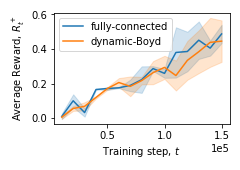

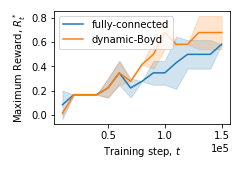

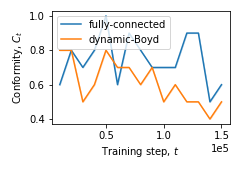

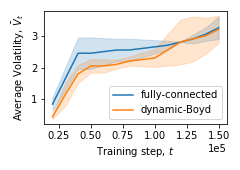

<Figure size 240.378x170.079 with 0 Axes>

<Figure size 240.378x170.079 with 0 Axes>

<Figure size 240.378x170.079 with 0 Axes>

<Figure size 240.378x170.079 with 0 Axes>

<Figure size 240.378x170.079 with 0 Axes>

<Figure size 240.378x170.079 with 0 Axes>

<Figure size 240.378x170.079 with 0 Axes>

<Figure size 240.378x170.079 with 0 Axes>

<Figure size 240.378x170.079 with 0 Axes>

In [ ]:
from scripts.evaluate import compare_projects

projects = ["projects/test_fully", "projects/test_dynamic"]
compare_projects(projects,"shape", save_dir = "projects/compare_fully_dynamic")



display(Image("projects/compare_fully_dynamic/plots/avg_norm_reward.png"),
        Image("projects/compare_fully_dynamic/plots/max_norm_reward.png"),
        Image("projects/compare_fully_dynamic/plots/avg_group_conformity.png"),
        Image("projects/compare_fully_dynamic/plots/avg_volatility.png"))


We can also compare the inter-group alignment for these projects (described in Section 6.4.3 of the paper). This will show us how much the two social network topologies differ in terms of their collective experience (measured as the number of different elements in the group replay buffers).

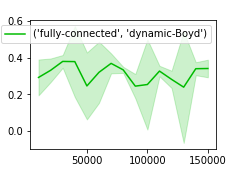

<Figure size 240.378x170.079 with 0 Axes>

In [ ]:
from scripts.compute_metrics import measure_intergroup_alignment
from scripts.plot import plot_intergroup_alignment

alignment = measure_intergroup_alignment(projects)
plot_intergroup_alignment(alignment, save_dir= "projects/compare_fully_dynamic")

display(Image("projects/compare_fully_dynamic/plots/inter_total.png"))